In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/MyDrive/ML dataset/"


In [ ]:
!pip install textstat

In [ ]:
import json
import pandas as pd
import numpy as np
import re
import string
import textstat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pairs_file = DATA_PATH + "pan20-authorship-verification-training-small.jsonl"
truth_file = DATA_PATH + "pan20-authorship-verification-training-small-truth.jsonl"

pairs = [json.loads(line) for line in open(pairs_file)]
truth = [json.loads(line) for line in open(truth_file)]


In [ ]:
label_map = {t["id"]: int(t["same"]) for t in truth}

In [ ]:
rows = []

for p in pairs:
    pid = p["id"]
    text1, text2 = p["pair"]
    label = label_map[pid]

    rows.append({
        "id": pid,
        "text1": text1,
        "text2": text2,
        "label": label
    })

df = pd.DataFrame(rows)
df["label"].value_counts()


,count
label,
1,27834
0,24767


Stylometry feature extraction

In [ ]:
def clean_text(text):
    return text.lower()


In [ ]:
def extract_features(text):
    text = clean_text(text)
    words = re.findall(r'\w+', text)
    sentences = re.split(r'[.!?]', text)

    features = {}

    # Lexical
    features["avg_word_len"] = np.mean([len(w) for w in words]) if words else 0
    features["type_token_ratio"] = len(set(words)) / len(words) if words else 0

    # Syntactic
    features["avg_sentence_len"] = np.mean([len(s.split()) for s in sentences if s.strip()]) if sentences else 0
    features["comma_freq"] = text.count(',') / len(text) if len(text) else 0
    features["semicolon_freq"] = text.count(';') / len(text) if len(text) else 0

    # Character-level
    features["punctuation_ratio"] = sum(1 for c in text if c in string.punctuation) / len(text) if len(text) else 0
    features["uppercase_ratio"] = sum(1 for c in text if c.isupper()) / len(text) if len(text) else 0
    features["digit_ratio"] = sum(1 for c in text if c.isdigit()) / len(text) if len(text) else 0

    # Readability (VERY IMPORTANT)
    features["flesch_reading_ease"] = textstat.flesch_reading_ease(text)
    features["gunning_fog"] = textstat.gunning_fog(text)

    return features


In [ ]:
feature_rows = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    f1 = extract_features(row["text1"])
    f2 = extract_features(row["text2"])

    diff = {k: abs(f1[k] - f2[k]) for k in f1}
    diff["label"] = row["label"]
    feature_rows.append(diff)

features_df = pd.DataFrame(feature_rows)


100%|██████████| 52601/52601 [51:40<00:00, 16.97it/s]


In [ ]:
FEATURE_ORDER = [
    "avg_word_len",
    "avg_sentence_len",
    "type_token_ratio",
    "punct_ratio",
    "comma_ratio",
    "period_ratio",
    "uppercase_ratio",
    "digit_ratio",
    "flesch_reading_ease",
    "gunning_fog",
    "smog_index"
]


In [ ]:
X = features_df.drop("label", axis=1)
y = features_df["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)


In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

models = {

    "Logistic Regression": LogisticRegression(max_iter=1000),

    "SVM (Linear Kernel)": SVC(
        kernel="linear",
        probability=True
    ),

    "Linear SVM (LinearSVC)": LinearSVC(),

    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ),

    "Decision Tree": DecisionTreeClassifier(
        random_state=42
    ),

    "KNN": KNeighborsClassifier(
        n_neighbors=5
    ),

    "Naive Bayes": GaussianNB(),

    "Ridge Classifier": RidgeClassifier(),

    "LDA (Linear Discriminant Analysis)": LinearDiscriminantAnalysis(),

    "XGBoost": XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )
}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [ ]:
results = []

for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    spec = tn / (tn + fp)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "Specificity": spec,
        "F1-score": f1
    })


Training Logistic Regression...
Training SVM (Linear Kernel)...
Training Linear SVM (LinearSVC)...
Training Random Forest...
Training Decision Tree...
Training KNN...
Training Naive Bayes...
Training Ridge Classifier...
Training LDA (Linear Discriminant Analysis)...
Training XGBoost...


In [ ]:
TRAIN_FEATURES = X.columns


In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-score", ascending=False)

results_df


,Model,Accuracy,Precision,Recall,Specificity,F1-score
9,XGBoost,0.762056,0.762929,0.798467,0.721131,0.780294
8,LDA (Linear Discriminant Analysis),0.738927,0.711783,0.851395,0.612517,0.775354
3,Random Forest,0.757113,0.760794,0.789127,0.721131,0.774702
2,Linear SVM (LinearSVC),0.718396,0.694707,0.834631,0.587752,0.758268
7,Ridge Classifier,0.711172,0.684144,0.843731,0.562180,0.755603
1,SVM (Linear Kernel),0.697104,0.667041,0.853790,0.520996,0.748950
0,Logistic Regression,0.692098,0.672461,0.815232,0.553701,0.736996
6,Naive Bayes,0.622141,0.586372,0.970662,0.230417,0.731094
4,Decision Tree,0.670173,0.688926,0.686864,0.651413,0.687894
5,KNN,0.612826,0.623064,0.679320,0.538089,0.649977


In [ ]:
results_df.to_csv("model_results.csv", index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)

def plot_metric(metric_name, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=metric_name,
        y="Model",
        data=results_df,
        palette="viridis"
    )
    plt.title(title)
    plt.xlabel(metric_name)
    plt.ylabel("Model")
    plt.xlim(0, 1)   # since all metrics are between 0 and 1
    plt.show()


/tmp/ipython-input-3054781055.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


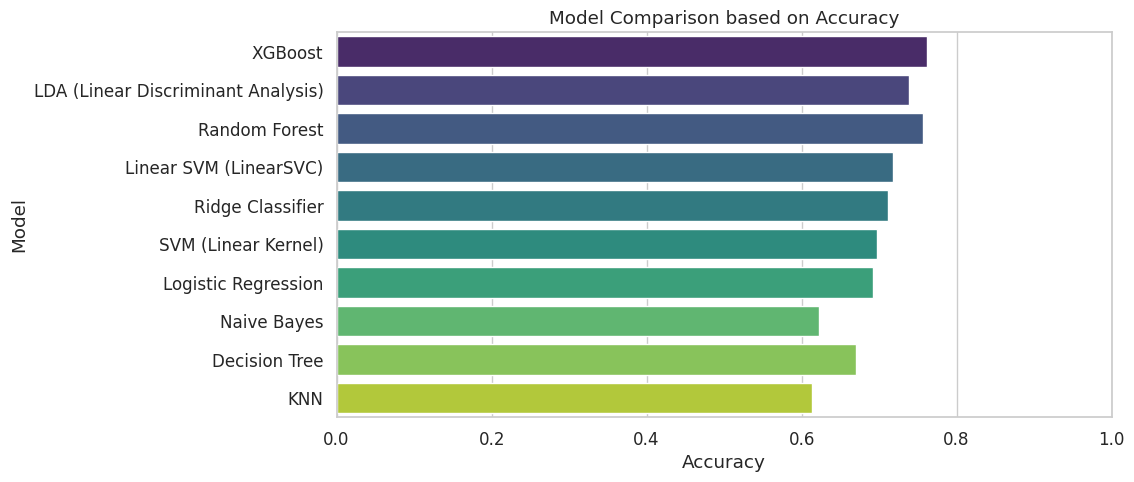

In [ ]:
plot_metric("Accuracy", "Model Comparison based on Accuracy")

/tmp/ipython-input-3054781055.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


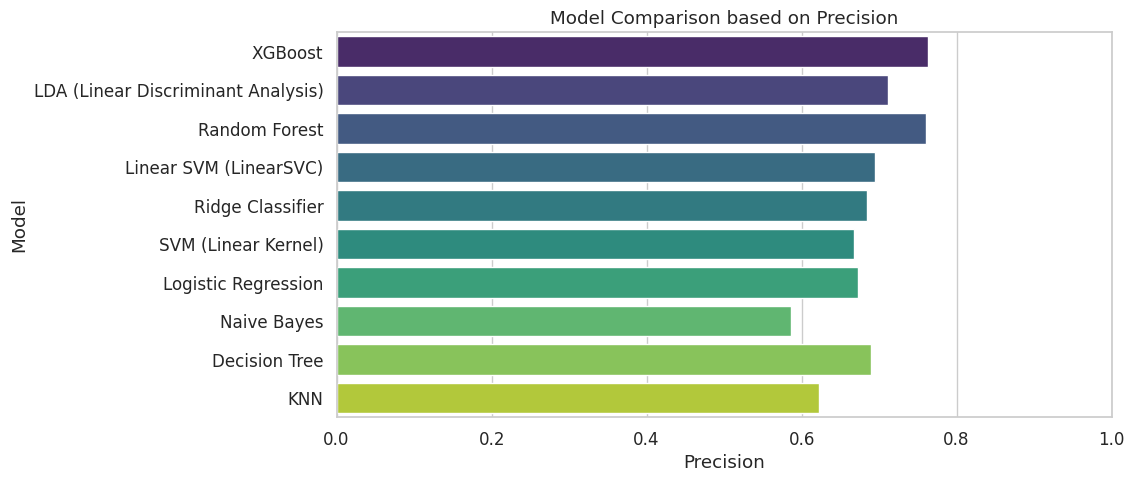

In [ ]:
plot_metric("Precision", "Model Comparison based on Precision")

/tmp/ipython-input-3054781055.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


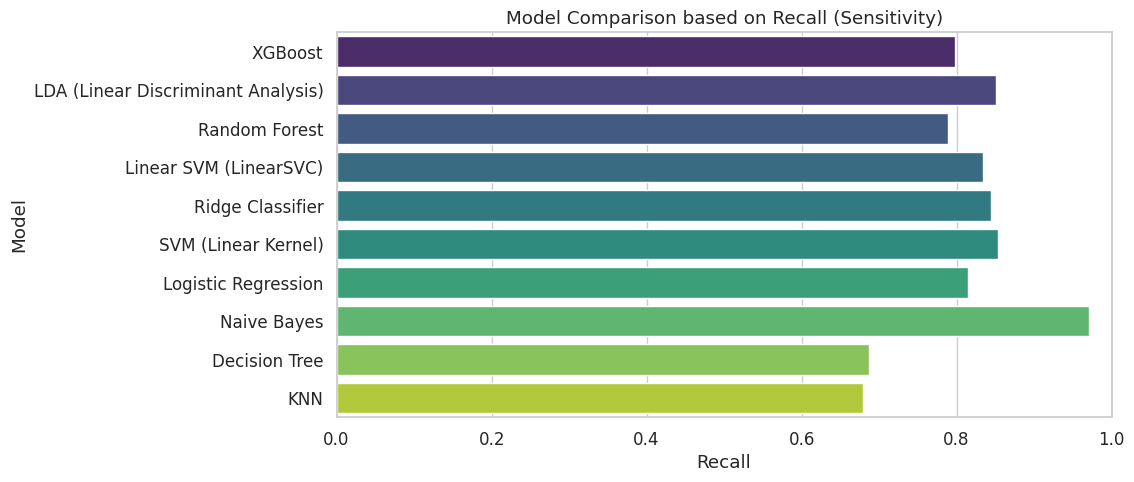

In [ ]:
plot_metric("Recall", "Model Comparison based on Recall (Sensitivity)")

/tmp/ipython-input-3054781055.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


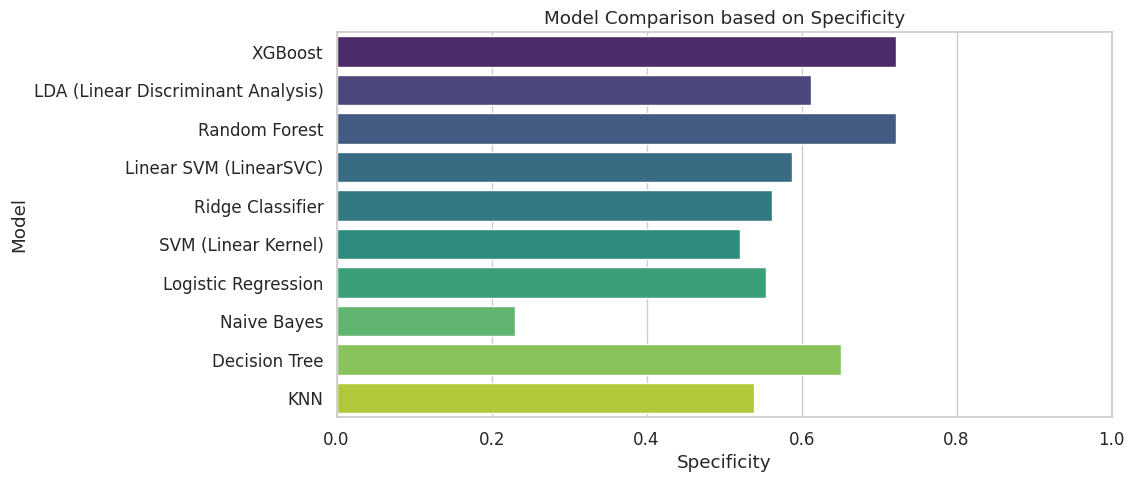

In [ ]:
plot_metric("Specificity", "Model Comparison based on Specificity")


/tmp/ipython-input-3054781055.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


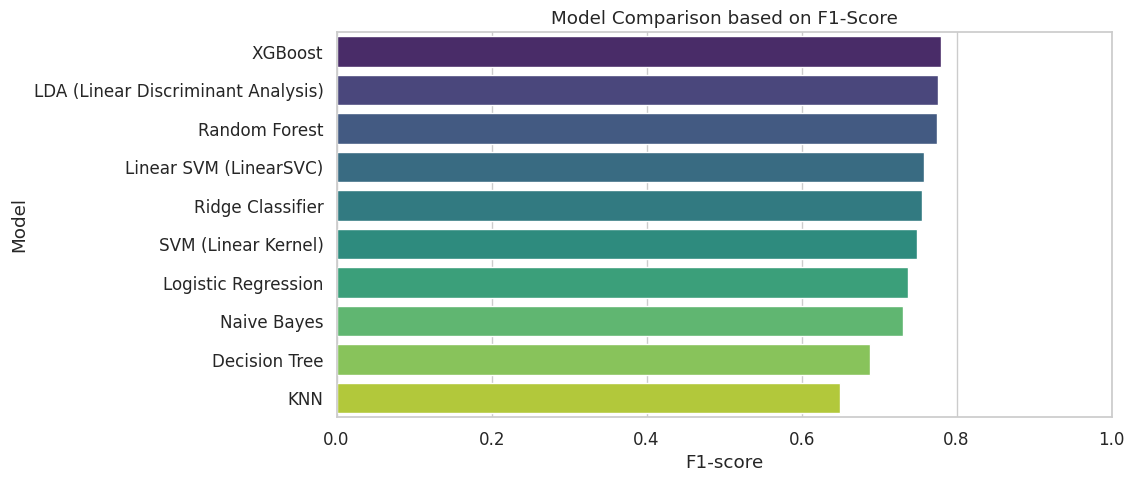

In [ ]:
plot_metric("F1-score", "Model Comparison based on F1-Score")


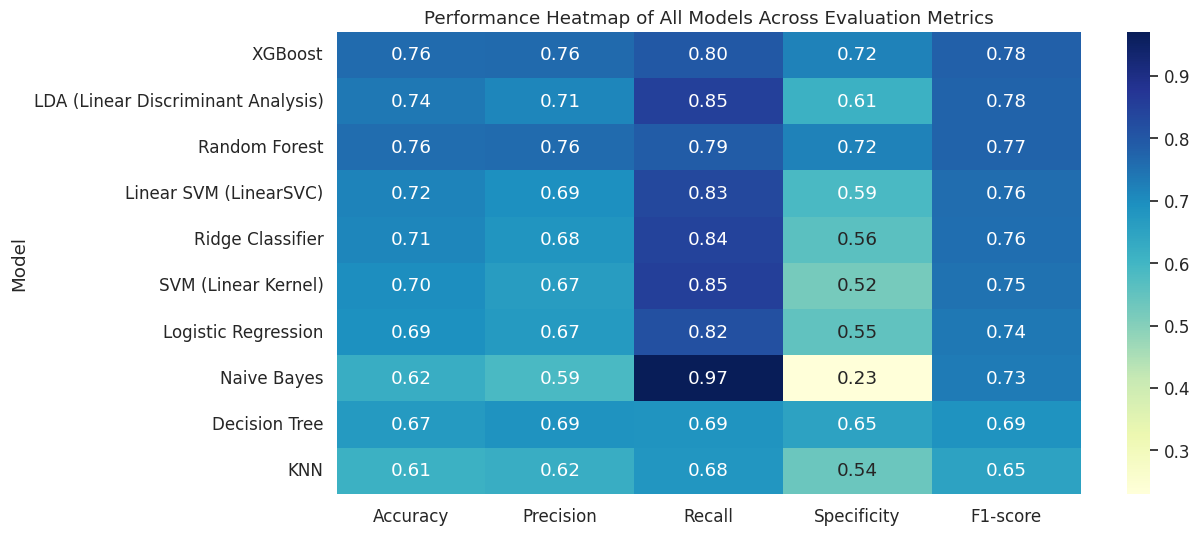

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    results_df.set_index("Model"),
    annot=True,
    cmap="YlGnBu",
    fmt=".2f"
)
plt.title("Performance Heatmap of All Models Across Evaluation Metrics")
plt.show()


In [ ]:
best_model = results_df.iloc[0]
best_model

,9
Model,XGBoost
Accuracy,0.762056
Precision,0.762929
Recall,0.798467
Specificity,0.721131
F1-score,0.780294


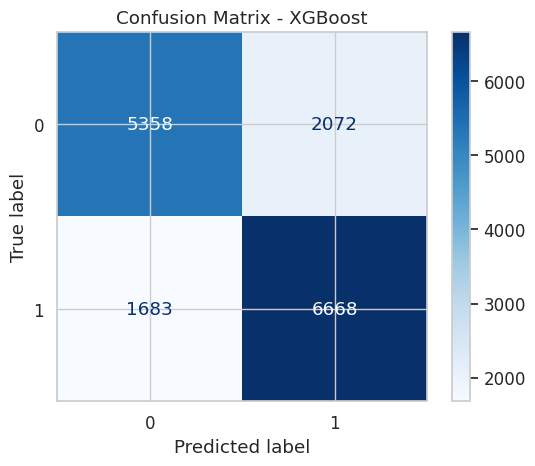

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

best_model_name = best_model["Model"]
model = models[best_model_name]

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap="Blues"
)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


In [ ]:
def predict_authorship(text1, text2, model):
    features_1 = extract_features(text1)
    features_2 = extract_features(text2)

    diff_features = np.abs(
        np.array(features_1) - np.array(features_2)
    ).reshape(1, -1)

    prediction = model.predict(diff_features)[0]

    if prediction == 1:
        return "Same Author"
    else:
        return "Different Author"


In [ ]:
def dict_to_vector(feature_dict):
    return np.array([feature_dict.get(f, 0.0) for f in FEATURE_ORDER])

In [ ]:
def predict_authorship(text1, text2, model):
    # extract features as dict
    f1 = extract_features(text1)
    f2 = extract_features(text2)

    # convert to DataFrame (1 row each)
    df1 = pd.DataFrame([f1])
    df2 = pd.DataFrame([f2])

    # align columns to training features
    df1 = df1.reindex(columns=TRAIN_FEATURES, fill_value=0)
    df2 = df2.reindex(columns=TRAIN_FEATURES, fill_value=0)

    # compute absolute difference
    diff_df = (df1 - df2).abs()

    # predict
    pred = model.predict(diff_df)[0]

    return "Same Author" if pred == 1 else "Different Author"


In [ ]:
text_a = "This assignment discusses machine learning concepts in education."
text_b = "Machine learning techniques are widely applied in educational systems."

print(predict_authorship(text_a, text_b, model))


Same Author


In [ ]:
sample_features = extract_features("This is a sample text for debugging.")
print(sample_features.keys())


dict_keys(['avg_word_len', 'type_token_ratio', 'avg_sentence_len', 'comma_freq', 'semicolon_freq', 'punctuation_ratio', 'uppercase_ratio', 'digit_ratio', 'flesch_reading_ease', 'gunning_fog'])


User input function

In [ ]:
def check_authorship(text_1, text_2, trained_model):
    """
    Input:
        text_1: First document text (string)
        text_2: Second document text (string)
        trained_model: trained ML classifier

    Output:
        Same Author / Different Author
    """

    # Extract features
    f1 = extract_features(text_1)
    f2 = extract_features(text_2)

    # Convert to DataFrame
    df1 = pd.DataFrame([f1])
    df2 = pd.DataFrame([f2])

    # Align with training feature schema
    df1 = df1.reindex(columns=TRAIN_FEATURES, fill_value=0)
    df2 = df2.reindex(columns=TRAIN_FEATURES, fill_value=0)

    # Absolute difference (stylometric distance)
    diff_df = (df1 - df2).abs()

    # Prediction
    prediction = trained_model.predict(diff_df)[0]

    if prediction == 1:
        return "Same Author"
    else:
        return "Different Author"


In [ ]:





print("Enter Text A (press Enter twice to finish):")
text_a = ""
while True:
    line = input()
    if line == "":
        break
    text_a += line + " "

print("\nEnter Text B (press Enter twice to finish):")
text_b = ""
while True:
    line = input()
    if line == "":
        break
    text_b += line + " "

best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

result = predict_authorship(text_a, text_b, best_model)

print("\nModel used:", best_model_name)
print("Authorship Result:", result)





Enter Text A (press Enter twice to finish):
I am kavya


Enter Text B (press Enter twice to finish):


Model used: XGBoost
Authorship Result: Different Author


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 49.8 MB/s eta 0:00:00


In [ ]:
import pdfplumber

def extract_text_from_pdf(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + " "
    return text


In [ ]:
text1 = extract_text_from_pdf("/content/Experiment-9 DHCP SERVER-1.pdf")
text2 = extract_text_from_pdf("/content/experiment-9.pdf")

print(predict_authorship(text1, text2, model))


Different Author


In [ ]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.5 MB/s eta 0:00:00


In [ ]:
from docx import Document

def extract_text_from_docx(docx_path):
    doc = Document(docx_path)
    text = " ".join([para.text for para in doc.paragraphs])
    return text


In [ ]:
text1 = extract_text_from_docx("/content/Exp-6 Dynamic Routing Protocol RIP.docx")
text2 = extract_text_from_docx("/content/Experiment-9 DHCP SERVER.docx")

print(predict_authorship(text1, text2, model))

Different Author


In [ ]:
def load_text(input_path):
    if input_path.endswith(".pdf"):
        return extract_text_from_pdf(input_path)
    elif input_path.endswith(".docx"):
        return extract_text_from_docx(input_path)
    elif input_path.endswith(".txt"):
        with open(input_path, "r", encoding="utf-8") as f:
            return f.read()
    else:
        raise ValueError("Unsupported file format")


In [ ]:
text1 = load_text("/content/Experiment-9 DHCP SERVER-1.pdf")
text2 = load_text("/content/Experiment-9 DHCP SERVER.docx")

print(predict_authorship(text1, text2, model))


Different Author


In [ ]:
best_model_name = results_df.sort_values("Accuracy", ascending=False).iloc[0]["Model"]
print(best_model_name)

XGBoost


In [ ]:
best_model = models[best_model_name]


In [ ]:
best_model.save_model("best_authorship_xgboost.json")


In [ ]:
from xgboost import XGBClassifier

loaded_model = XGBClassifier()
loaded_model.load_model("best_authorship_xgboost.json")


In [ ]:
import joblib
joblib.dump(best_model, "best_authorship_model.pkl")


['best_authorship_model.pkl']

In [ ]:
best_model = joblib.load("best_authorship_model.pkl")
